In [2]:
from ssfm.files import *
import numpy as np
from numba import jit

import matplotlib.pyplot as plt
import trimesh

## Read files

In [3]:
mesh_f = '../../data/box_canyon_park/SfM_products/model.obj'

tri_mesh = trimesh.load(mesh_f)

In [4]:
vertices = tri_mesh.vertices
faces = tri_mesh.faces
print("# Vertices: ", vertices.shape)
print("# Faces: ", faces.shape)
print("Bounds: ", tri_mesh.bounds)

# print some examples of the vertices and faces
print("Vertices: ", vertices[:5])
print("Faces: ", faces[:5])

# Vertices:  (4848412, 3)
# Faces:  (9217583, 3)
Bounds:  [[4.32574421e+05 3.74958410e+06 1.32213862e+02]
 [4.32936969e+05 3.74990560e+06 2.10247117e+02]]
Vertices:  [[4.32923721e+05 3.74964016e+06 1.54768085e+02]
 [4.32898206e+05 3.74960091e+06 1.44520859e+02]
 [4.32919001e+05 3.74963290e+06 1.55375528e+02]
 [4.32898214e+05 3.74960093e+06 1.44517384e+02]
 [4.32910171e+05 3.74961932e+06 1.46417276e+02]]
Faces:  [[73708 71990 73719]
 [71993 73712 72002]
 [73710 71990 73708]
 [71993 71990 73710]
 [73712 71993 73710]]


In [29]:
# read camera parameters
camera_intrinsics_file = '../../data/box_canyon_park/SfM_products/camera.json'
camera_intrinsics, distortion_params = read_camera_intrinsics_webodm(camera_intrinsics_file)
print(camera_intrinsics)


camera_list_file = "../../data/box_canyon_park/SfM_products/shots.geojson"
cameras = read_camera_extrinsics_webodm(camera_list_file)
extrinsic_matrix = cameras['DJI_0184.JPG']
print(extrinsic_matrix)

image_height = cameras['height']
image_width = cameras['width']
print(image_height, image_width)

[[3.55241856e+03 0.00000000e+00 2.76411893e+03]
 [0.00000000e+00 3.55241856e+03 1.81903216e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[ 7.38943357e-01 -6.63287893e-01  1.18371814e-01  4.32728668e+05]
 [-6.73749815e-01 -7.26155976e-01  1.36962352e-01  3.74975997e+06]
 [-4.88906939e-03 -1.80960408e-01 -9.83478229e-01  2.00558314e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
3648 5472


## Transform vertices to local coordinates

In [6]:
@jit(nopython=True)
def update_image_and_associations(z_buffer, points, height, width):
    pixel2point = np.full((height, width), -1, dtype=np.int32)

    N_points = points.shape[0]

    for i in range(N_points):
        x, y, z = points[i]
        px, py = int(x), int(y)

        if 0 <= px < width and 0 <= py < height:
            if z < z_buffer[py, px]:
                z_buffer[py, px] = z
                pixel2point[py, px] = i

    # get the pixel of valid associations
    u_indices, v_indices = np.where(pixel2point != -1)
    point2pixel = np.full((N_points, 2), -1, dtype=np.int16)
    for idx in range(len(u_indices)):
        point2pixel[pixel2point[u_indices[idx], v_indices[idx]]] = np.array([u_indices[idx], v_indices[idx]])

    return z_buffer, pixel2point, point2pixel

In [7]:
# Transform the point cloud using the extrinsic matrix
points_homogeneous = np.hstack((vertices, np.ones((len(vertices), 1))))

extrinsic_matrix_inv = np.linalg.inv(extrinsic_matrix)

points_transformed = np.matmul(points_homogeneous, extrinsic_matrix_inv.T)

In [8]:
# Project the points using the intrinsic matrix
# Drop the homogeneous component (w)
points_camera_space = points_transformed[:, :3]

points_projected_d = np.matmul(points_camera_space, camera_intrinsics.T)
points_projected = points_projected_d / points_projected_d[:, -1].reshape(-1, 1)
# replace depth 
points_projected[:, 2] = points_projected_d[:, 2]

# Initialize image (2D array) and z-buffer
z_buffer = np.full((image_height, image_width), np.inf)


# Update image and get associations
z_buffer, pixel2point, point2pixel = update_image_and_associations(z_buffer, points_projected, image_height, image_width)


In [9]:
# get vertices that are associated with pixels on the image
ids_valid_vertices = np.unique(pixel2point[pixel2point != -1])

print(ids_valid_vertices)
print(len(ids_valid_vertices))

# Check if each vertex in each face is in ids
overlap_mask = np.isin(faces, ids_valid_vertices)

# Determine if each face has any vertex that overlaps with ids
mask_valid_faces = np.any(overlap_mask, axis=1)

[2286865 2286867 2288704 ... 3747095 3747099 3748441]
223024


## Generate depth image from face rasterization

In [10]:
@jit(nopython=True)
def edge_function(a, b, c):
    return (c[0] - a[0]) * (b[1] - a[1]) - (c[1] - a[1]) * (b[0] - a[0])

@jit(nopython=True)
def rasterize_depth_image(faces, points_projected, image_height, image_width):
    depth_image = np.full((image_height, image_width), np.inf)

    for face in faces:
        v0, v1, v2 = points_projected[face[0]], points_projected[face[1]], points_projected[face[2]]

        min_x = max(0, int(np.floor(min([v0[0], v1[0], v2[0]]))))
        max_x = min(image_width-1, int(np.ceil(max([v0[0], v1[0], v2[0]]))))
        min_y = max(0, int(np.floor(min([v0[1], v1[1], v2[1]]))))
        max_y = min(image_height-1, int(np.ceil(max([v0[1], v1[1], v2[1]]))))

        area = edge_function(v0, v1, v2)
        if area == 0:
            continue

        for x in range(min_x, max_x + 1):
            for y in range(min_y, max_y + 1):
                p = np.array([x + 0.5, y + 0.5])
                w0 = edge_function(v1, v2, p)
                w1 = edge_function(v2, v0, p)
                w2 = edge_function(v0, v1, p)

                if w0 >= 0 and w1 >= 0 and w2 >= 0:
                    w0 /= area
                    w1 /= area
                    w2 /= area

                    depth = w0 * v0[2] + w1 * v1[2] + w2 * v2[2]
                    if depth < depth_image[y, x]:
                        depth_image[y, x] = depth

    return depth_image

depth_image = rasterize_depth_image(faces[mask_valid_faces], points_projected, image_height, image_width)

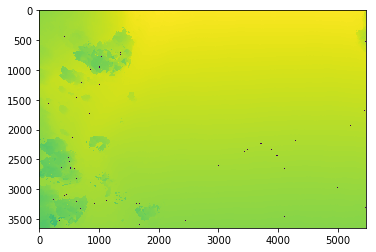

In [11]:
depth_image = np.where(depth_image == np.inf, 0, depth_image)
plt.imshow(depth_image)
plt.show()

## Verify with depth image from point clouds

In [12]:
# read point cloud file
las_file = '../../data/box_canyon_park/SfM_products/model.las'
points, colors = read_las_file(las_file)

In [13]:
# Transform the point cloud using the extrinsic matrix
points_homogeneous = np.hstack((points, np.ones((len(points), 1))))

extrinsic_matrix_inv = np.linalg.inv(extrinsic_matrix)

points_transformed = np.matmul(points_homogeneous, extrinsic_matrix_inv.T)

points_camera_space = points_transformed[:, :3]

points_projected_d = np.matmul(points_camera_space, camera_intrinsics.T)
points_projected = points_projected_d / points_projected_d[:, -1].reshape(-1, 1)
# replace depth 
points_projected[:, 2] = points_projected_d[:, 2]

# Initialize image (2D array) and z-buffer
z_buffer = np.full((image_height, image_width), np.inf)

# Update image and get associations
z_buffer, pixel2point, point2pixel = update_image_and_associations(z_buffer, points_projected, image_height, image_width)

In [14]:
# get depth image from pixel2point and points_projected 
depth_image_ = np.full((image_height, image_width), 0)
valid_indices = pixel2point != -1
depth_image_[valid_indices] = points_projected[pixel2point[valid_indices], 2]

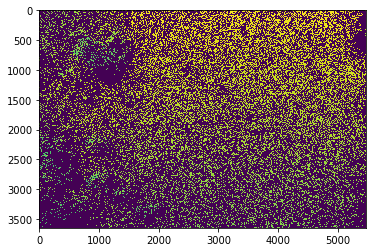

In [15]:
plt.imshow(depth_image_)
plt.show()

14447254


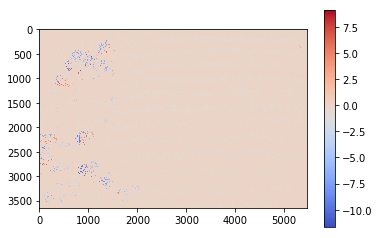

In [33]:
img1 = depth_image.copy() # mesh depth image
img2 = depth_image_.copy() # point cloud depth image

# compare img1 and img2
img1[img2 == 0] = 0
img2[img1 == 0] = 0

# count the True values of (img2 == 0) & (img1 == 0)
zero_count = np.sum((img2 == 0) & (img1 == 0))
print(zero_count)

diff = img2 - img1 
# negative values mean mesh is in front of point cloud; or point cloud is behind mesh
# positive values mean mesh is in behind point cloud; or point cloud is in front of mesh

# plot diff with color map
plt.imshow(diff, cmap='coolwarm')
plt.colorbar()
plt.show()

In [17]:
# print the range of the difference
print(np.min(diff), np.max(diff))

-11.683727036714842 9.106728068941365


In [44]:
threshold = -1
# count of number of pixels with difference less than 0; mesh is in front of point cloud
print(np.sum(diff < threshold))
# print the percentage of pixels with difference less than 0
print(np.sum(diff < threshold) / (image_height * image_width - zero_count) * 100 ) 

# count of number of pixels with difference greater than 0; mesh is behind point cloud
print(np.sum(diff > threshold) - zero_count)
# print the percentage of pixels with difference greater than 0
print((np.sum(diff > threshold) - zero_count) / (image_height * image_width - zero_count) * 100 ) 

np.sum(diff < 0) + np.sum(diff > 0) + zero_count == image_height * image_width


278300
5.046601731185678
5236302
94.95339826881433


True

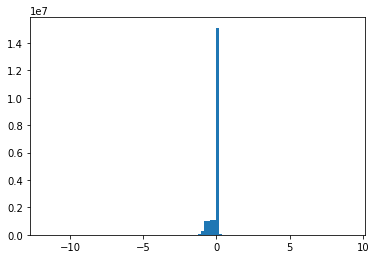

In [19]:
# plot the histogram of the difference
plt.hist(diff.flatten(), bins=100)
plt.show()

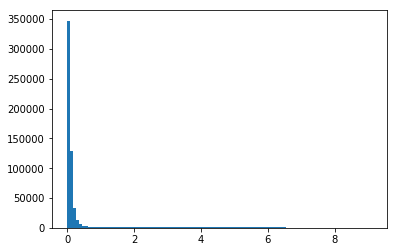

In [20]:
# plot the histogram of the difference greater than 0
# those are the points that are in front of the mesh

plt.hist(diff[diff > 0].flatten(), bins=100)
plt.show()

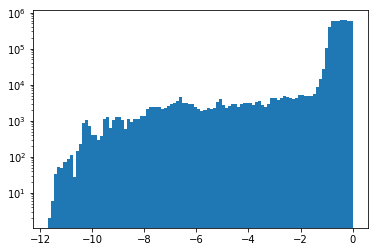

In [21]:
# plot the histogram of the difference greater than 0
# those are the points that are behind the mesh

plt.hist(diff[diff < 0].flatten(), bins=100)
plt.yscale('log')
plt.show()

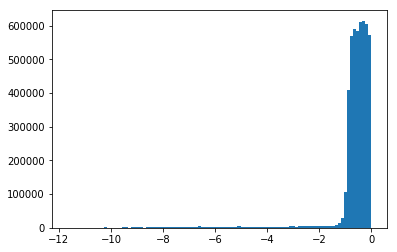

In [22]:
# plot the histogram of the difference smaller than 0
# those are the points that are in front of the mesh

plt.hist(diff[diff < 0].flatten(), bins=100)
plt.show()

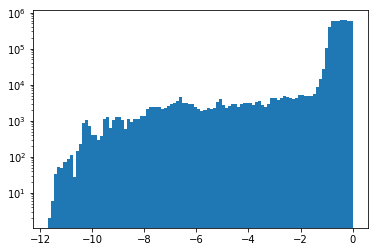

In [23]:
# plot the histogram of the difference smaller than 0
# those are the points that are in front of the mesh
# the a logaritmic scale is used to better visualize the distribution

plt.hist(diff[diff < 0].flatten(), bins=100)
plt.yscale('log')
plt.show()

## Obtain points behind the mesh

In [45]:
ids_save_points = pixel2point[diff < threshold]

points_save = points[ids_save_points]
colors_save = colors[ids_save_points]

write_las(points_save, colors_save, '../../data/box_canyon_park/points_behind_mesh.las')

In [27]:
ids_save_points = pixel2point[diff == 0]

points_save = points[ids_save_points]
colors_save = colors[ids_save_points]

write_las(points_save, colors_save, '../../data/box_canyon_park/points_on_mesh.las')

In [46]:
ids_save_points = pixel2point[diff > threshold]

points_save = points[ids_save_points]
colors_save = colors[ids_save_points]

write_las(points_save, colors_save, '../../data/box_canyon_park/points_front_mesh.las')